In [3]:
import cv2 
import os
import random
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# tensorflow dependencies 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)


In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# uncompress Tar GZ Labelled Faces in the Wild Dataser
!tar -xf lfw.tgz

In [ ]:
# move LFW Img to the following dir
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid # create unique id

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[190:190+250, 430:430+250, :]

    #collect anchors 
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # Create the unique file path
        cv2.imwrite(imgname, frame) # Write out anchor image

    #collect positive
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) # Create the unique file path
        cv2.imwrite(imgname, frame) # Write out anchor image

    # image back on screen
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Load and preprocess images

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(400)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) # load in the image

    # preprocess
    img = tf.image.resize(img, (100, 100))
    img /= 255.0
    return img
    

In [10]:
# Create Labelled Dataser

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [14]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()
exampple

(b'data/anchor/1d410ad2-0d5e-11ee-9356-bedbc1d9773b.jpg',
 b'data/positive/ffbeffc2-0d5e-11ee-9356-bedbc1d9773b.jpg',
 1.0)

# Build Train and Test Partition  

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*exampple)

In [28]:
res[2]

1.0

# Build data pipeline

In [29]:
data = data.map(preprocess_twin)
data = data.cache() 
data = data.shuffle(buffer_size=1024)

In [31]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.5852941 , 0.5539216 , 0.5107843 ],
         [0.5776961 , 0.54632354, 0.5012255 ],
         [0.577451  , 0.55196077, 0.49803922],
         ...,
         [0.6605392 , 0.6252451 , 0.55857843],
         [0.64460784, 0.61519605, 0.54558825],
         [0.6404412 , 0.6129902 , 0.54240197]],
 
        [[0.57916665, 0.5477941 , 0.5026961 ],
         [0.56666666, 0.5387255 , 0.48602942],
         [0.589951  , 0.56642157, 0.5115196 ],
         ...,
         [0.65612745, 0.6286765 , 0.55710787],
         [0.63014704, 0.60269606, 0.53186274],
         [0.6460784 , 0.6186274 , 0.5480392 ]],
 
        [[0.5767157 , 0.5512255 , 0.49730393],
         [0.5808824 , 0.55735296, 0.49656862],
         [0.5757353 , 0.55220586, 0.49142158],
         ...,
         [0.6340686 , 0.6066176 , 0.53210783],
         [0.6487745 , 0.6213235 , 0.547549  ],
         [0.64705884, 0.61960787, 0.54901963]],
 
        ...,
 
        [[0.35465688, 0.35465688, 0.30882353],
         [0.1504902 , 0.16004902, 0.11299

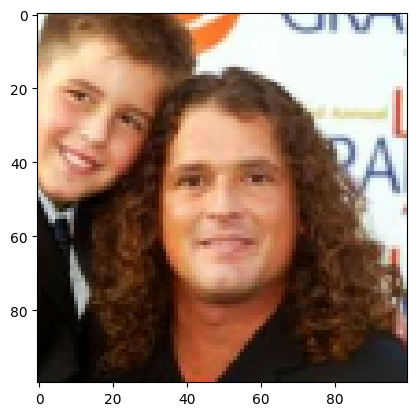

In [87]:
sampl = samples.next()
plt.imshow(sampl[1])

In [88]:
sampl[2]

0.0

In [89]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [90]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [91]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))